In [41]:
# multi-client
import numpy as np
import matplotlib.pyplot as plt

def run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m, common_theta):
    d = 10
    V0 = lambda_ * np.eye(d)
    theta0 = np.zeros(d)

    def generate_decision_set(d, num_actions=1000):
        actions = np.random.randn(num_actions, d)
        actions = actions / np.linalg.norm(actions, axis=1, keepdims=True)
        return actions

    thetas = common_theta
    print(f"10 thetas: ","\n", thetas)
    At = generate_decision_set(d)
    optimal_reward_list = [] 
    for client in range (m):
        optimal_reward = max(At.dot(thetas[client]))
        optimal_reward_list.append(optimal_reward)

    def compute_beta_t(d, m, delta, sigma, T,lambda_min_C,lambda_max_C,lambda_max_Cq):
        term1 = (
            1 / lambda_min_C * (1 + 1 / m + sigma**-2 * lambda_min_C) + sigma**2 / m * T
        ) ** 0.5
        term2 = (sigma**2 + lambda_max_C) ** 2 / (m**2 * lambda_max_Cq) + m * (
            sigma**2 + lambda_max_C
        )
        term3 = (m / (lambda_min_C + (sigma**2 / T))) * np.sqrt(
            2 * d * sigma**2 + 8 * sigma**2 * np.log(2 * m * T / delta)
        )
        gamma1 = term1 * term2 * term3
        gamma2 = (
            1 / lambda_min_C * (1 + 1 / m + sigma**-2 * lambda_min_C) + sigma**2 / m * T
        ) ** 0.5
        gamma2 *= (
            (sigma**2 + lambda_max_C)
            / (m + (sigma**2 + lambda_max_C) * 1/lambda_max_Cq)
            * lambda_max_Cq
            * np.linalg.norm(mu_q)
        )
        beta_t = gamma1 + gamma2 + np.sqrt(2 * d + 8 * np.log(2 * m * T / delta))
        return beta_t
    
    def compute_C_hat(C_inv, Gi_t, C_bar_t):
        C_tilde = np.linalg.inv(C_inv + Gi_t)
        C_hat = C_tilde + C_tilde @ C_inv @ C_bar_t @ C_inv @ C_tilde
        return C_hat

    def compute_mut_t(G_inv_list, bi_t_list, C_bar_t,t):
        sum_term = np.zeros((d, 1))
        for Gi_t_inv, bi_t in zip(G_inv_list, bi_t_list):
            term1 = np.linalg.inv(C + Gi_t_inv)
            sum_term += np.matmul(Gi_t_inv, bi_t)
        mu_t = C_bar_t @ sum_term
        mu_t = mu_t.flatten()  # Ensure mu_t has the correct shape
        return mu_t
        
    def compute_confidence_set_center(mu_t, C_inv, Gi_t, bi_t):
        return np.linalg.inv(C_inv + Gi_t) @ (C_inv @ mu_t + bi_t)

    lambda_min_C = np.linalg.eigvals(C).min()
    lambda_max_C = np.linalg.eigvals(C).max()
    lambda_max_Cq = np.linalg.eigvals(C_q).max()
    Gi_t = [np.zeros((d,d)) for _ in range(m)] 
    bi_t = [np.zeros(d).reshape((10,1)) for _ in range(m)] 
    C_bar_t = np.eye(d)
    C_hat = [np.zeros((d,d)) for _ in range(m)]
    confidence_set_center = [np.zeros(d).reshape((10,1)) for _ in range(m)] 
    all_regrets = [[] for _ in range(m)]
    beta_t = compute_beta_t(
                d,
                m,
                delta,
                np.sqrt(noise_variance),
                n_rounds,
                lambda_min_C,
                lambda_max_C,
                lambda_max_Cq,
            )
    for t in range(1, n_rounds + 1):     
        G_inv_list = []  
        bi_t_list = [] 
        sum_C_inv_plus_Gi_t_inv = np.zeros((d, d))
        for client in range(m):
            Vt = V0
            theta_t = theta0
            total_possible_reward = 0
            total_reward = 0
            #regrets = []
            if t <= d:
                At = [np.eye(d)[:, t-1]] 
            else:
                At = generate_decision_set(d)
            #At = generate_decision_set(d)
            if t<= d:
                At_selected = At[0]
            else: 
                ucb_values = [
                    confidence_set_center[client].T @ (a.reshape((d,1))) 
                    + beta_t * np.sqrt(a.reshape((1,d)) @ (np.linalg.inv(C_hat[client])) @ a.reshape((d,1)))
                    for a in At
                ]
                max_index = np.argmax(ucb_values)
                At_selected = At[max_index]
            Xt = At_selected.dot(thetas[client]) # + np.random.randn() * np.sqrt(noise_variance )
            total_possible_reward += optimal_reward_list[client]
            total_reward += Xt
            regret = max (0, optimal_reward_list[client] - Xt)
            all_regrets[client].append(regret)
            Gi_t[client] += 1/ noise_variance * np.outer(At_selected, At_selected)
            bi_t[client] += 1 / noise_variance * At_selected.reshape((10,1)) * Xt 
            if t >= d:
                Gi_t_inv = np.linalg.inv(Gi_t[client]) 
                G_inv_list.append(Gi_t_inv)
                bi_t_list.append(bi_t[client])
                sum_C_inv_plus_Gi_t_inv += np.linalg.inv(C + Gi_t_inv)
                #print(f"Trial {t}, Client {client+1}: = Regret: {regret}")
        if t >= d: 
            C_bar_t = np.linalg.inv(sum_C_inv_plus_Gi_t_inv)
            for client in range(m):
                C_inv = np.linalg.inv(C)
                mu_t = compute_mut_t(G_inv_list, bi_t_list, C_bar_t, t).reshape((10,1))
                confidence_set_center[client] = compute_confidence_set_center(mu_t, C_inv, G_inv_list[client], bi_t_list[client])
                C_hat[client] = compute_C_hat(C_inv, G_inv_list[client], C_bar_t)
    for client in range(m):
        #all_regrets[client] = np.cumsum(all_regrets[client]) / np.arange(1, n_rounds + 1)
        #cumulative sum
        all_regrets[client] = np.cumsum(all_regrets[client]) 
    return all_regrets


In [42]:
#single client 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import pandas as pd
from IPython.display import display
from matplotlib import rcParams

def run_algorithm(lambda_, delta, n_rounds, noise_variance, common_theta):
    # Initialize
    d = 10
    V0 = lambda_ * np.eye(d)
    theta0 = np.zeros(d)

    # theta* from a multivariable Gaussian distribution 
    theta_star = common_theta
    print(f"local client theta: ","\n", theta_star)

    # 1. decision set
    def generate_decision_set(d, num_actions=1000):
        actions = np.random.randn(num_actions, d)
        actions = actions / np.linalg.norm(actions, axis=1, keepdims=True)  # unit ball
        return actions

    # 2. regularized least-squares estimate
    def compute_theta(V, actions, rewards):
        return np.linalg.inv(V).dot(actions.T.dot(rewards))

    # 3. confidence set
    def construct_confidence_set(theta, V, beta):
        return theta, beta * np.linalg.inv(V)  # ellipsoid

    # 4. UCB computation
    def compute_ucb(actions, theta, invV, beta):
        ucb_values = []
        for a in actions:
            ucb_value = theta.dot(a) + beta * np.sqrt(a.T.dot(invV).dot(a))
            ucb_values.append(ucb_value)
        return np.array(ucb_values)

    # compute beta_t (confidence bound parameter)
    def compute_beta_t(t, d, lambda_, delta=0.001):
        return np.sqrt(lambda_) + np.sqrt(
            2 * np.log(1 / delta) + d * np.log((1 + t / (lambda_ * d)))
        )

    # Run the algorithm for n rounds
    actions_list = []
    rewards_list = []
    total_possible_reward = 0
    total_reward = 0
    regrets = []
    distances = []

    for t in range(1, n_rounds + 1):
        At = generate_decision_set(d)
        if t == 1:
            Vt = V0
            theta_t = theta0
        else:
            Vt = V0 + np.dot(np.array(actions_list).T, np.array(actions_list))
            theta_t = compute_theta(Vt, np.array(actions_list), np.array(rewards_list))
        invVt = np.linalg.inv(Vt)
        beta_t = compute_beta_t(t, d, lambda_, delta)
        confidence_set_center, confidence_set_matrix = construct_confidence_set(
            theta_t, Vt, beta_t
        )
        ucb_values = compute_ucb(At, confidence_set_center, invVt, beta_t)
        # 5. select action with highest UCB
        At_selected = At[np.argmax(ucb_values)]
        # 6. simulate observe reward
        Xt = At_selected.dot(theta_star) + np.random.randn() * np.sqrt(noise_variance)  # add Gaussian noise
        # optimal reward
        optimal_reward = max(At.dot(theta_star))
        total_possible_reward += optimal_reward
        total_reward += Xt
        regret = optimal_reward - Xt
        regrets.append(regret)
        # Calculate distance to true theta
        distance = np.linalg.norm(theta_t - theta_star)
        distances.append(distance)
        # 7. Update history
        actions_list.append(At_selected)
        rewards_list.append(Xt)
    # Compute cumulative regret and regret per trial
    cumulative_regret = np.cumsum(regrets)
    regret_per_trial = cumulative_regret / np.arange(1, n_rounds + 1)

    return cumulative_regret
    #return regrets, cumulative_regret, regret_per_trial

client 1 theta:  
 [-0.35181368  0.93802591  1.26350675 -0.3505078   1.67438749  0.68749101
 -2.53230319  0.28630401  0.11402763  0.39969156]


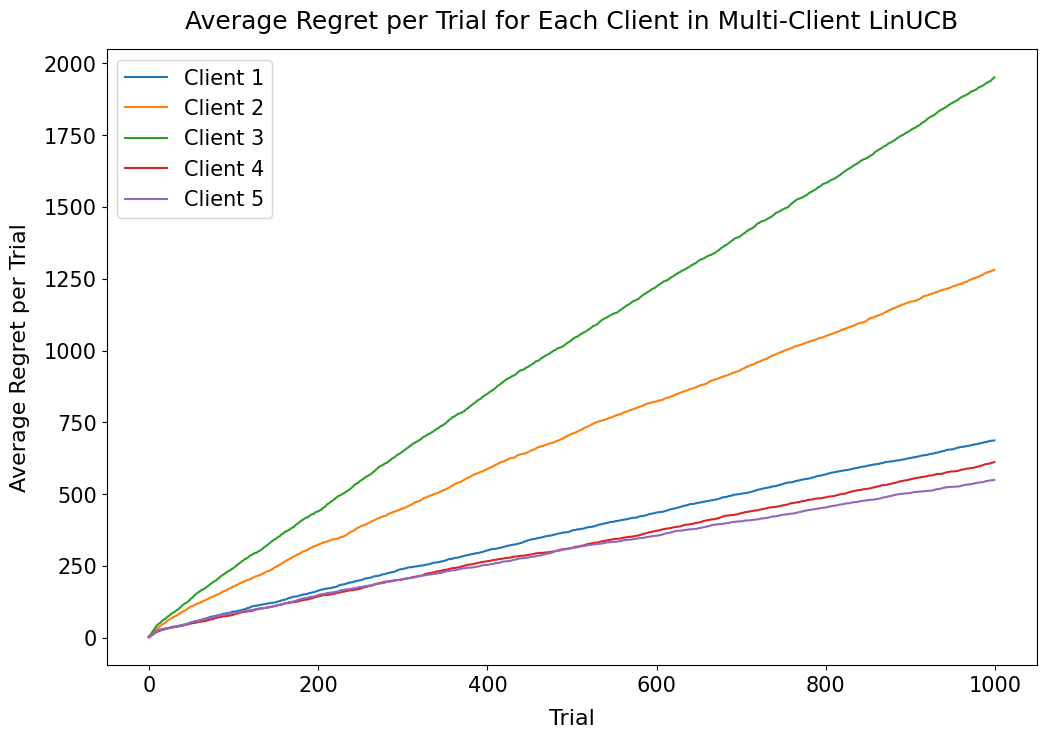

In [27]:
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.01
m = 5  #clients
d= 10

# Generate a common theta* for all clients
mu_q = np.zeros(d)
C_q = np.eye(d)
C = np.eye(d)
def generate_common_theta():
    mu = np.random.multivariate_normal(mu_q, C_q)
    thetas = [np.random.multivariate_normal(mu, C) for _ in range(m)]
    return thetas

common_theta = generate_common_theta()

all_regrets = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m, common_theta)

# Plotting the result
plt.figure(figsize=(12, 8))
for i, client_regret in enumerate(all_regrets):
    #regret_per_trial = client_regret / np.arange(1, n_rounds + 1)
    plt.plot(client_regret, label=f"Client {i+1}")

plt.xlabel("Trial",fontsize =16, labelpad =10)
plt.ylabel("Average Regret per Trial",fontsize =16, labelpad =10)
plt.title("Average Regret per Trial for Each Client in Multi-Client LinUCB",pad = 15 ,fontsize= 18)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [28]:
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.01
m = 5  #clients
d= 10

# Generate a common theta* for all clients
mu_q = np.zeros(d)
C_q = np.eye(d)
C = np.eye(d)
def generate_common_theta():
    mu = np.random.multivariate_normal(mu_q, C_q)
    thetas = [np.random.multivariate_normal(mu, C) for _ in range(m)]
    return thetas

common_theta = generate_common_theta()
# Run the local model
cum_regret_local = run_algorithm(lambda_, delta, n_rounds, noise_variance, common_theta[0])
# Run the collaborative model
cum_regret_collaborative = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m, common_theta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cum_regret_local, label='Local Training (Single Client)', color='blue')
for i, client_regret in enumerate(cum_regret_collaborative):
    plt.plot(client_regret, label=f"Multi-Client {i+1}")
plt.xlabel('Rounds',fontsize =16,labelpad =10 )
plt.ylabel('Cumulative Regret', fontsize =16, labelpad =10 )
plt.title('Comparison of Local vs Collaborative Training',pad = 15 ,fontsize= 18)
plt.legend(fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Calculate the final regret or average over all rounds regret difference
final_regret_difference = cum_regret_collaborative[-1] - cum_regret_local[-1]
avg_regret_difference = np.mean(cum_regret_collaborative) - cum_regret_local

print(f'Average Regret Difference over all rounds: {avg_regret_difference}')

local client theta:  
 [-0.39292058  0.54636691 -1.21128299 -0.70390536  0.19291479 -2.25899041
 -0.24125376  2.06202162 -1.2806893   0.40001308]


KeyboardInterrupt: 

10 thetas:  
 [array([-1.67988159,  0.99865121,  0.43966714,  0.2868487 , -0.3261598 ,
        1.21223784,  1.02753519,  0.81664343, -0.70655282,  0.57247695]), array([-1.91343269,  0.25689604,  0.29177847,  0.99207822,  1.1072151 ,
        1.86673377,  0.75000037,  0.02155603,  1.43469093, -1.20788131]), array([-2.37524777,  0.7820422 , -0.24381259,  1.44159317, -0.48096985,
        2.73782787, -0.33527154,  1.45761922,  1.48452537,  0.02584726]), array([-2.32634596, -1.59285935,  0.76277121, -0.21296759, -0.58175137,
        1.81730401, -0.3210732 ,  1.77707137,  2.55195983,  0.80369152]), array([-1.28058291,  1.29170219, -0.19252959,  0.38506877, -0.38832133,
        2.76915419,  0.38928053,  0.29997994,  0.69294839,  0.86327193]), array([-3.00739236,  1.29777826, -0.433607  , -0.84080439,  0.26939635,
        0.4008903 ,  1.16282706, -0.52048297,  0.18986455, -0.57417042]), array([-1.34064105, -1.13791188,  1.41885525,  0.99498672, -1.28329248,
        3.68668479,  0.04824672,  2.6

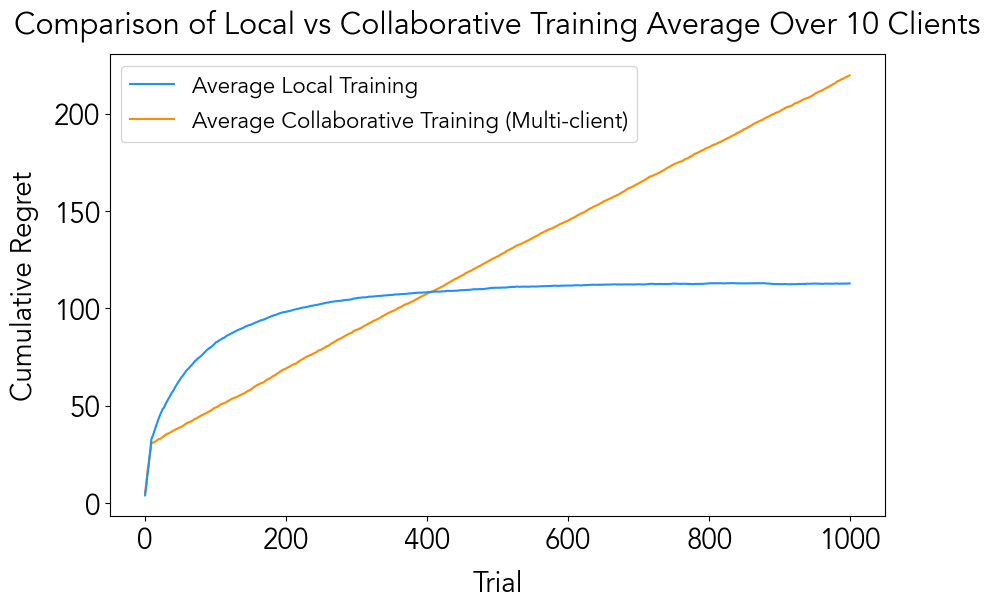

Average Percentage Improvement: -18.05%


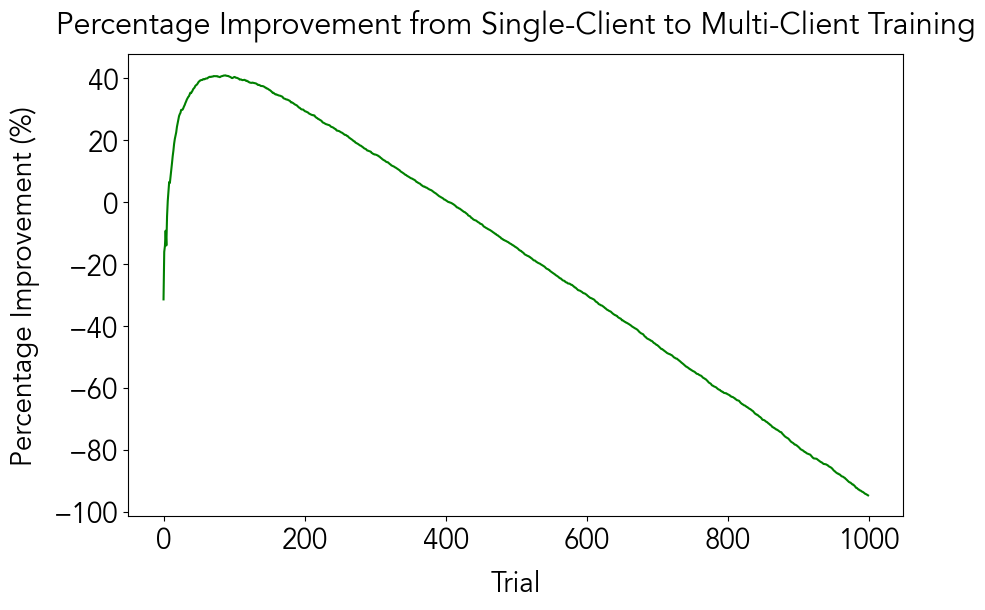

In [47]:
#comparison of models averaged
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.001
m = 10  #clients
d = 10

# Generate a common theta* for all clients
mu_q = np.zeros(d)
C_q = np.eye(d)
C = np.eye(d)

def generate_common_theta():
    mu = np.random.multivariate_normal(mu_q, C_q)
    thetas = [np.random.multivariate_normal(mu, C) for _ in range(m)]
    return thetas

common_theta = generate_common_theta()
# Function to run multi-client and single-client algorithms
def run_comparison(lambda_, delta, n_rounds, noise_variance, m, common_theta):
    all_regrets_multi_client = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m, common_theta)
    avg_cumulative_regret_multi_client = np.mean(all_regrets_multi_client, axis=0)

    all_regrets_single_client = []
    for client in range(m):
        regrets_single_client = run_algorithm(lambda_, delta, n_rounds, noise_variance, common_theta[client])
        print ("single clients number:",client)
        all_regrets_single_client.append(regrets_single_client)
    
    avg_cumulative_regret_single_client = np.mean(all_regrets_single_client, axis=0)

    return avg_cumulative_regret_multi_client, avg_cumulative_regret_single_client

avg_cumulative_regret_multi_client, avg_cumulative_regret_single_client = run_comparison(lambda_, delta, n_rounds, noise_variance, m, common_theta)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Avenir'  
plt.rcParams['font.monospace'] = 'Avenir Mono'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_cumulative_regret_multi_client, label='Average Collaborative Training (Multi-client)', color='darkorange')
plt.plot(avg_cumulative_regret_single_client, label="Average Local Training", color = 'dodgerblue')
plt.xlabel('Trial',fontsize=20, labelpad =10 )
plt.ylabel('Cumulative Regret', fontsize=20, labelpad =10)
plt.title('Comparison of Local vs Collaborative Training Average Over 10 Clients',pad = 15 ,fontsize= 22)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=16, loc='best')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculate percentage improvement
percentage_improvement = (avg_cumulative_regret_single_client - avg_cumulative_regret_multi_client) / avg_cumulative_regret_single_client * 100
average_percentage_improvement = np.mean(percentage_improvement)
print(f"Average Percentage Improvement: {average_percentage_improvement:.2f}%")

# Plot percentage improvement
plt.figure(figsize=(10, 6))
plt.plot(percentage_improvement, label="Percentage Improvement (Multi-client over Single-client)", color='green')
plt.xlabel('Trial', fontsize=20, labelpad=10)
plt.ylabel('Percentage Improvement (%)', fontsize=20, labelpad=10)
plt.title('Percentage Improvement from Single-Client to Multi-Client Training', pad=15, fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()